In [1]:
import os
import itertools 
import numpy as np
import cv2
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
plt.style.use("seaborn-whitegrid")
plt.rc("figure",autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold",titlesize=14, titlepad=10)

In [2]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0).squeeze().map(str)
path = os.getcwd() + '\images\image_train'
#Create a column with the name of the picture
X['image_name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image_path'] = path + r'\image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

In [3]:
print(X['image_name'].loc[100])
print(X['image_path'].loc[100])

image_1321747763_product_4223031202.jpg
C:\Users\utilisateur\Documents\PROJET RAKUTEN\images\image_train\image_1321747763_product_4223031202.jpg


In [4]:
image_size = (50,50)
path_list = list(X['image_path'][:30000])
index_list = list(X[:30000].index)
label_list = list(y[:30000])
images_tuples = []
for path, idx, label in zip(path_list,index_list,label_list):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray_red = cv2.resize(img_gray, dsize = (image_size),interpolation = cv2.INTER_LANCZOS4 )
    images_tuples.append((idx,label,img_gray_red))

In [ ]:
# cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_LANCZOS4, cv2.INTER_CUBIC (cv2 resize interpolation methods)
# HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

In [9]:
column_names = ['index','label']
for pixel in range(image_size[0]*image_size[1]):
    column_names.append('pixel'+str(pixel+1))

images_list = []
for image in images_tuples:
    idx,label,img = image
    pixel_list = [idx,label]###
    for row_pixels in img:
        for pixel in row_pixels:
            pixel_list.append(pixel)
    images_list.append(pixel_list)
    ###
rakuten_images = pd.DataFrame(images_list,columns=column_names)
rakuten_images

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,0,10,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,2462,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29996,29996,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29997,29997,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29998,29998,1920,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [10]:
rakuten_images.to_csv('rakuten_reduced_all_images190821.csv',index_label='idx')

In [11]:
rakuten_reduced_images = pd.read_csv('rakuten_reduced_all_images190821.csv',index_col='index')
rakuten_reduced_images.drop(columns=['idx'],inplace=True)

In [12]:
target = rakuten_images['label']
data = rakuten_images.drop('label',1)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
data_scaled = data /255
X_pca=pca.fit_transform(data_scaled)
components_names = [f"PC{i+1}" for i in range (X_pca.shape[1])]
X_pca=pd.DataFrame(X_pca, columns=components_names)
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-58.80,-10.68,0.32,2.38,0.07,-0.16,0.79,0.62,-0.04,-0.48,...,0.34,0.09,-0.32,0.62,0.27,-0.09,-0.03,-0.26,0.06,-0.34
1,-58.80,-8.35,-0.37,-1.33,0.40,-2.25,3.47,2.81,-0.79,-1.15,...,-0.02,0.03,0.03,-1.02,-0.57,0.03,-0.95,-1.43,-0.00,-0.12
2,-58.79,-11.17,0.48,3.92,0.26,0.03,-1.08,-0.17,0.01,0.32,...,0.26,-0.06,-0.16,0.03,0.25,0.51,-0.02,-0.36,-0.12,-0.05
3,-58.83,9.48,-2.96,-9.19,2.52,0.13,-5.04,-1.17,1.22,-2.50,...,-2.26,-0.15,-0.21,1.51,0.23,0.30,1.23,-2.14,1.28,0.74
4,-58.79,-7.74,-0.63,-1.26,1.46,-2.65,2.31,2.79,-0.78,0.83,...,-1.57,-0.16,-0.86,0.51,0.24,-0.15,-0.86,-0.51,-0.34,-1.01


In [14]:
def plot_variance (pca, width=8, dpi=100):
    fig,axs=plt.subplots(1,2)
    n = pca.n_components_
    grid=np.arange(1,n+1)
    evr=pca.explained_variance_ratio_
    axs[0].bar(grid,evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0,1.0))
    
    cumv=np.cumsum(evr)
    axs[1].plot(np.r_[0,grid], np.r_[0,cumv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0,1.0))
       
    fig.set(figwidth=8, dpi=100)
    return axs

load = pd.DataFrame(pca.components_,columns=components_names, index=X.columns)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

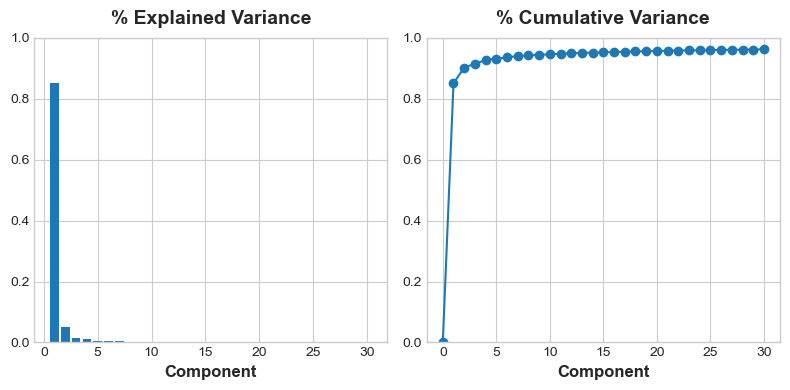

In [15]:
plot_variance(pca)

In [23]:
def make_mi_scores(X,y,discrete_features):
    mi_scores = mutual_info_regression(X,y,discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores=mi_scores.sort_values(ascending=False)
    return mi_scores

def score_model(model, X_t=X_train, y_t=y_train, X_te=X_test, y_te=y_test):
    model.fit(X_t,y_t)
    preds=model.predict(X_te)
    return f1_score (y_te,preds,average='weighted')

def conf_matx(model, y_te=y_test, X_te=X_test):
    
    #Variable target avec les labels organisées:
    y_organised = ['10','2280','2403','2705','2522',
               '40','50','2905','2462','60',
               '1280','1281','1300','1180','1140','1160',
               '1320','1560',
               '2582','2583','2585','1302','2220',
               '1920','2060',
               '1301','1940']
    
    
    preds=model.predict(X_te)
    cnf_matrix = metrics.confusion_matrix(y_test,preds,labels=y_organised)
    y_organised

    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell/sum(line),2))
        pond_matrix.append(pond_line)
    cnf_matrix = np.array(pond_matrix)
    classes = y_organised

    plt.figure(figsize=(17,17))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Y TRUE')
    plt.xlabel(' PREDICTION')
    plt.show()

In [18]:
mi_scores=make_mi_scores(X_pca, target, discrete_features=False)
mi_scores

PC3    0.28
PC2    0.13
PC14   0.11
PC7    0.10
PC5    0.09
PC12   0.09
PC21   0.09
PC4    0.07
PC8    0.07
PC20   0.07
PC6    0.07
PC27   0.06
PC10   0.06
PC26   0.06
PC11   0.05
PC15   0.05
PC9    0.05
PC22   0.04
PC18   0.04
PC28   0.04
PC13   0.04
PC30   0.03
PC23   0.03
PC19   0.03
PC16   0.03
PC17   0.03
PC25   0.03
PC24   0.03
PC29   0.02
PC1    0.00
Name: MI Scores, dtype: float64

In [19]:
pca.fit(data)
print("composantes retenues :", pca.n_components_)

composantes retenues : 30


In [20]:
pca = PCA(n_components = 30)
X_train = data[:20000]
X_test = data[20000:]
X_train_scaled = X_train /255
X_test_scaled = X_test /255
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [22]:
y_train = y[X_train.index]
y_test = y[X_test.index]
print(y_train.shape, y_test.shape)

(20000,) (10000,)


In [24]:
# mod 1 
from sklearn.ensemble import RandomForestClassifier
m1_rf = RandomForestClassifier(n_jobs = -1, random_state=1)
score_model(m1_rf, X_train_pca, y_train, X_test_pca, y_test)

0.3213429025437509

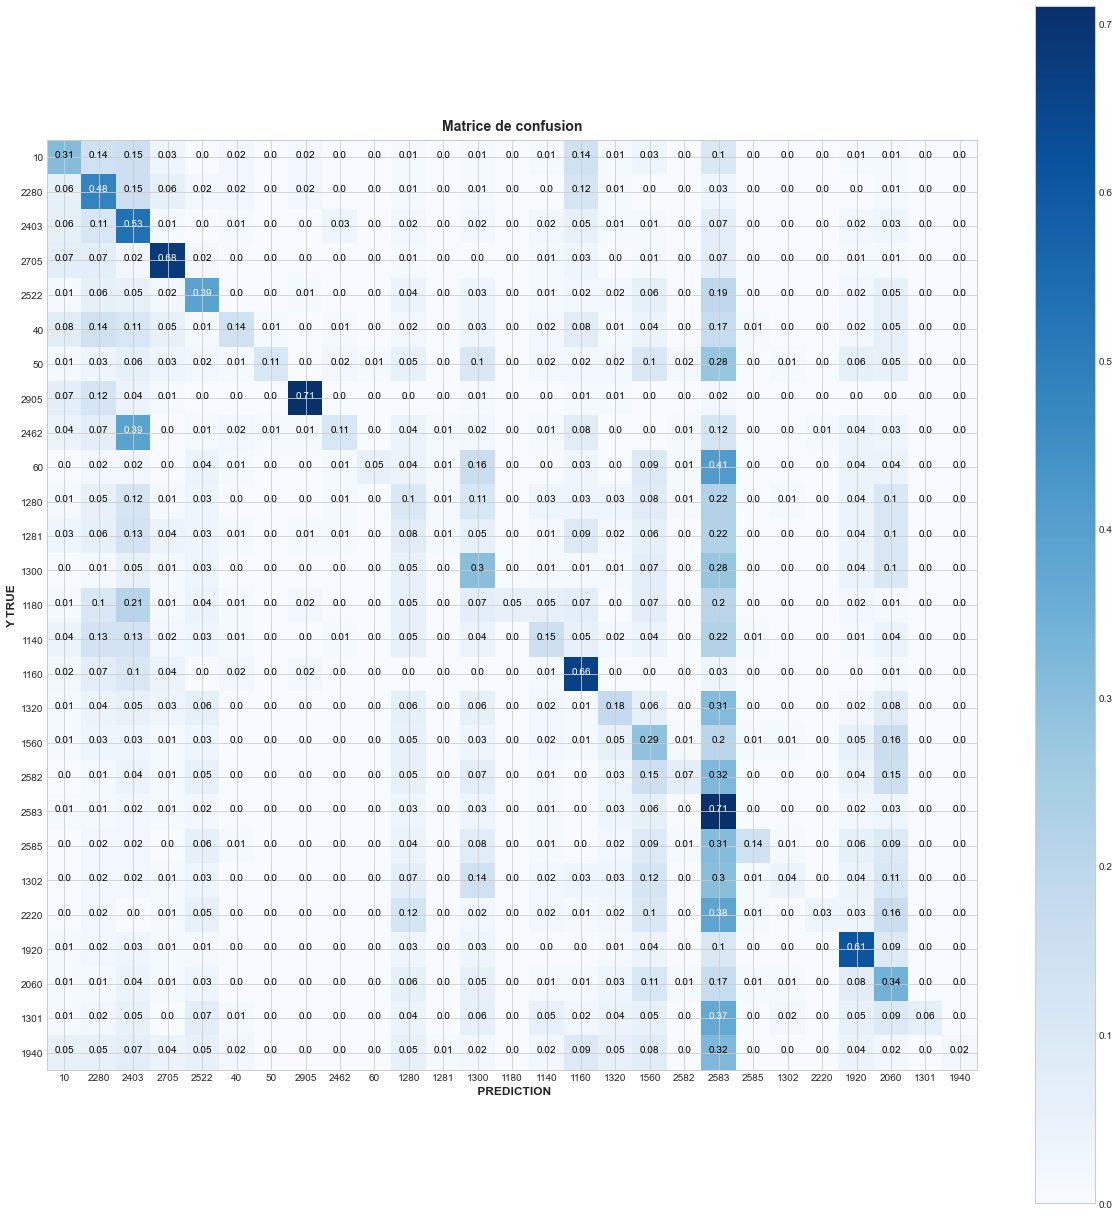

In [25]:
conf_matx(m1_rf,y_test,X_test_pca)

In [48]:
# mod 2 XGBOOST
# from xgboost import XGBClassifier
m2_xgb = XGBClassifier(n_jobs = -1)
score_model(m2_xgb, X_train_pca, y_train, X_test_pca, y_test)

0.2929408355656558

In [ ]:
conf_matx(m2_xgb,y_test,X_test_pca)

In [ ]:
preds=m2_xgb.predict(X_test_pca)

In [ ]:
preds

In [ ]:
indexes = [i for i in range(len(preds))]
indexes

In [ ]:
images = 8
j=1
plt.figure(figsize = (20,20))
#plt.subplot(10,5,1)
plt.axis('off')

for i in np.random.choice(indexes, size = images):
    #img = cv2.imread(path + '\\' + X_test_pca[i]['image_name'])  #X['image_path']
    img = cv2.imread(path + '\\' + X[i]['image_name'])
    img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
    #img = cv2.imread(path + '\\' + X_test_img.iloc[0]['image_name'], cv2.IMREAD_COLOR)
    #img = img.reshape(28, 28)
      
    plt.subplot(4,2,j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary, interpolation='None')
    plt.title('True Label: ' + classes[str(y_te[i])] + '\n' + 'Prediction: '+ classes[str(preds[i])] )
             #+ '\n' + 'Confidence: '+ str(round(np.max(y_pred_prob, axis=1)[i],2)))

### TESTS METHODES COMPLENTAIRES DE MACHINE LEARNING AVEC LA METHODE LAZY PREDICT

#Lazypredict is one of the best one-liner packages I have ever seen.

Using the library, you can train almost all Sklearn models plus XGBoost and LightGBM in a single line of code. It only has two estimators — one for regression and one for classification. Fitting either one on a dataset with a given target will evaluate more than 30 base models and generate a report with their rankings on several popular metrics



In [6]:
pip install lazypredict

  Using cached lazypredict-0.2.9-py2.py3-none-any.whl (12 kB)
  Using cached lightgbm-2.3.1-py2.py3-none-win_amd64.whl (544 kB)
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.2.1
    Uninstalling lightgbm-3.2.1:
      Successfully uninstalled lightgbm-3.2.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from lazypredict.Supervised import (LazyClassifier,LazyRegressor)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [32]:
lazcl = LazyClassifier(ignore_warnings=True, random_state=1, verbose=False)
models, predictions = lazcl.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [2:45:13<00:00, 341.83s/it]  


In [37]:
models.head(50)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.40,0.31,None,0.37,34.78
RandomForestClassifier,0.40,0.31,None,0.37,55.69
LGBMClassifier,0.39,0.30,None,0.36,326.00
XGBClassifier,0.38,0.29,None,0.35,800.33
BaggingClassifier,0.33,0.27,None,0.32,233.55
SVC,0.34,0.25,None,0.30,1520.29
DecisionTreeClassifier,0.27,0.22,None,0.26,38.28
KNeighborsClassifier,0.27,0.22,None,0.25,579.98
LinearDiscriminantAnalysis,0.27,0.22,None,0.26,359.96


In [38]:
from joblib import dump, load

dump(models, 'md.joblib')

['md.joblib']

In [42]:
loaded_model = load('md.joblib')

#loaded_model.predict(X_test)
#loaded_model.score(X_test, y_test)

In [41]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.40,0.31,None,0.37,34.78
RandomForestClassifier,0.40,0.31,None,0.37,55.69
LGBMClassifier,0.39,0.30,None,0.36,326.00
XGBClassifier,0.38,0.29,None,0.35,800.33
BaggingClassifier,0.33,0.27,None,0.32,233.55
SVC,0.34,0.25,None,0.30,1520.29
DecisionTreeClassifier,0.27,0.22,None,0.26,38.28
KNeighborsClassifier,0.27,0.22,None,0.25,579.98
LinearDiscriminantAnalysis,0.27,0.22,None,0.26,359.96


In [47]:
import pickle
pickle.dump(models, open(models, 'wb'))

# LA méthode pickle ne fonctionne pas avec lazy predictor


TypeError: expected str, bytes or os.PathLike object, not DataFrame

In [ ]:
# Fit LazyClassifier -> ne fonctionne pas avec les données préprocessées type PCA
lazcl = LazyClassifier(ignore_warnings=True, random_state=1, verbose=False)
#models, predictions = lazcl.fit(X_train_pca, y_train, X_test_pca, y_test)  # pass all sets
score_model(lazcl, X_train_pca, y_train, X_test_pca, y_test)
#models.head(10)